In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Reading the output of the autoML algorithm searching for best models for biscuits
df=pd.read_csv('biscuitModels28_11_2022.csv',index_col='Unnamed: 0')
#shuffle splits of 10, 2 thirds splits
# 3.9.13 python,  matplotlib==3.5.1
df.columns

Index(['feature_preprocessor_type', 'feature_preprocessor_hyperparams',
       'regressor', 'regressor_hyperparams', 'data_preprocessor_type',
       'data_preprocessor_hyperparams', 'R2', 'R2normalized',
       'ENSEMBLE WEIGHT', 'ENSEMBLE WEIGHT normalized', 'MEAN FIT TIME',
       'MEAN FIT TIME normalized'],
      dtype='object')

In [26]:
#Reformatting models dataframe
df.replace(np.nan,{},regex=True)
regressor_hyperparams=df['regressor_hyperparams'].map(eval,na_action='ignore').apply(pd.Series)
df=df.drop('regressor_hyperparams',axis=1)
data_hyperparams=df['data_preprocessor_hyperparams'].map(eval,na_action='ignore').apply(pd.Series)
df=df.drop('data_preprocessor_hyperparams',axis=1)
feature_hyperparams=df['feature_preprocessor_hyperparams'].map(eval,na_action='ignore').apply(pd.Series)
df=df.drop('feature_preprocessor_hyperparams',axis=1)
df.sort_values(by=['R2'],inplace = True,ascending=False)
for column in regressor_hyperparams:
    regressor_hyperparams.loc[regressor_hyperparams[column].notnull(), column]=regressor_hyperparams.loc[regressor_hyperparams[column].notnull(),column].apply(lambda x: x['data'] )
for column in data_hyperparams:
    data_hyperparams.loc[data_hyperparams[column].notnull(), column]=data_hyperparams.loc[data_hyperparams[column].notnull(),column].apply(lambda x: x['data'] )
for column in feature_hyperparams:
    feature_hyperparams.loc[feature_hyperparams[column].notnull(), column]=feature_hyperparams.loc[feature_hyperparams[column].notnull(),column].apply(lambda x: x['data'] )
    

<AxesSubplot:xlabel='regressor'>

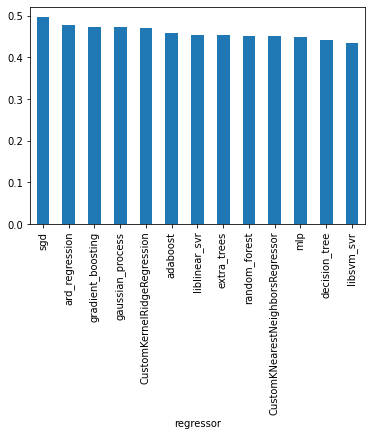

In [27]:
#models over r2 threshold
threshold=0.4
overdf = df.drop(df[df['R2']<threshold].index)
r2ByModel=overdf.groupby(['regressor'])['R2'].mean()
r2ByModel.sort_values(inplace = True,ascending=False)
r2ByModel.plot.bar()

<AxesSubplot:title={'center':'Regressor type counts of the best 1431 models (by R2)'}, xlabel='regressor'>

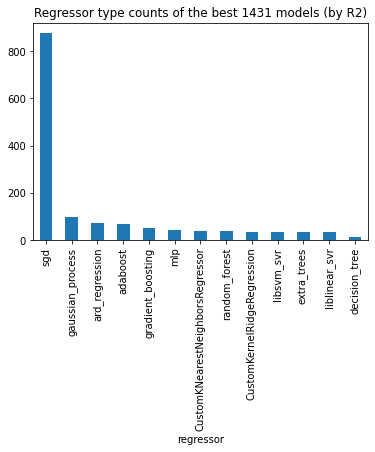

In [28]:
#another view of best models
r2ByModel=overdf.groupby(['regressor'])['R2'].mean()
r2ByModel.sort_values(inplace = True,ascending=False)
r2ByModel.plot.bar()

r2ByModel=overdf.groupby(['regressor'])['R2'].count()
r2ByModel.sort_values(inplace = True,ascending=False)
r2ByModel.plot.bar(title='Regressor type counts of the best '+str(len(overdf))+' models (by R2)')

In [29]:
#joining model dataframes
regressor_hyperparams = regressor_hyperparams.add_suffix('_regressor_hyperparams')
feature_hyperparams = feature_hyperparams.add_suffix('_feature_hyperparams')
data_hyperparams = data_hyperparams.add_suffix('_data_hyperparams')

df=df.join(regressor_hyperparams)
df=df.join(feature_hyperparams)
df=df.join(data_hyperparams)
df.to_csv('parsedModels.csv')

In [30]:
#df2 will only contain models used in best ensemble, and those will be the only ones tested next
df2=df[df['ENSEMBLE WEIGHT'] > 0].dropna(how='all',axis=1)

In [31]:
# Mutual Information and Pearson correlations of the predictors to target variable bioaccessibility
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

dfData=pd.read_csv('forAutoML.csv',index_col='Unnamed: 0')
dfData = dfData.drop(dfData[dfData.Water > 500].index)
X=dfData.copy()
y=dfData.pop('bioaccessibility')
corrs=X.corr()
X.pop('bioaccessibility')
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
print('mi_scores')
print(mi_scores)
corrs=corrs.reindex(corrs.bioaccessibility.abs().sort_values(ascending=False).index)
print('pearson coefficients')
print(corrs['bioaccessibility'])

mi_scores
Crème max texture                               0.482469
Biscuit breaking point                          0.435442
Ash                                             0.424298
Carbs                                           0.410950
Water                                           0.407375
Crème min texture                               0.403863
Bulk density                                    0.397041
Cellulose                                       0.386051
Hemicellulose                                   0.385983
C                                               0.384277
Tapped density                                  0.382857
Exp. Water retention final                      0.381142
D 4 3 - Volume weighted mean (particle size)    0.371033
Binding capacity (micromolar)                   0.355213
h                                               0.351613
a                                               0.343634
Fructans                                        0.340431
Insoluble fiber      

In [32]:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor,RandomTreesEmbedding
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ARDRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import sklearn.feature_selection
import math 

#big loop to rebuild the ensemble with best model algorithms using their final configurations by reading df2 (models of the final ensemble)
models=[]
ensemble_weights=[]
count=0


count=1
for index, row in df2.iterrows():
    pipeline=[]
    if row['numerical_transformer_imputation_strategy_data_hyperparams']!=np.nan:
        pipeline.append(('sklearn.impute.SimpleImputer',SimpleImputer(strategy=row['numerical_transformer_imputation_strategy_data_hyperparams'])))
    
    if row['numerical_transformer_rescaling_data_hyperparams']=='minmax':
        pipeline.append(('sklearn.preprocessing.MinMaxScaler',MinMaxScaler()))
    if row['numerical_transformer_rescaling_data_hyperparams']=='quantile_transformer':
        pipeline.append(('sklearn.preprocessing.QuantileTransformer',QuantileTransformer(n_quantiles=row['numerical_transformer_rescaling_quantile_transformer_n_quantiles_data_hyperparams'],output_distribution=row['numerical_transformer_rescaling_quantile_transformer_output_distribution_data_hyperparams'])))
    
    if row['numerical_transformer_rescaling_data_hyperparams']=='robust_scaler':
        from scipy import sparse
        X_train, X_valid, y_train, y_valid=train_test_split(dfData, y,train_size=0.666, test_size=0.333,random_state=2)
        rs = ShuffleSplit(n_splits=1, test_size=.33, random_state=0)
        rs.get_n_splits(X_train)
        for train_index, test_index in rs.split(X_train):
            X_train2=X_train.iloc[train_index,:]
        if sparse.isspmatrix(X_train2):
            pipeline.append(('sklearn.preprocessing.RobustScaler',RobustScaler(with_centering=False,copy=False,quantile_range=(row['numerical_transformer_rescaling_robust_scaler_q_min_data_hyperparams'],row['numerical_transformer_rescaling_robust_scaler_q_max_data_hyperparams']))))
        else:
            pipeline.append(('sklearn.preprocessing.RobustScaler',RobustScaler(copy=False,quantile_range=(row['numerical_transformer_rescaling_robust_scaler_q_min_data_hyperparams'],row['numerical_transformer_rescaling_robust_scaler_q_max_data_hyperparams']))))
        
    if row['numerical_transformer_rescaling_data_hyperparams']=='power_transformer':
        pipeline.append(('sklearn.preprocessing.PowerTransformer',PowerTransformer()))
    
    if row['feature_preprocessor_type']=='polynomial':
        pipeline.append(('sklearn.preprocessing.PolynomialFeatures',sklearn.preprocessing.PolynomialFeatures(degree=row['degree_feature_hyperparams'],include_bias=row['include_bias_feature_hyperparams'],interaction_only=row['interaction_only_feature_hyperparams'])))
    elif row['feature_preprocessor_type']=='feature_agglomeration':
        n_clusters=29 if row['n_clusters_feature_hyperparams']>29 else  row['n_clusters_feature_hyperparams']
        pooling_func_dict=dict(mean=np.mean, median=np.median, max=np.max)
        pipeline.append(('sklearn.cluster.FeatureAgglomeration',FeatureAgglomeration(affinity=row['affinity_feature_hyperparams'],linkage=row['linkage_feature_hyperparams'],n_clusters=n_clusters,pooling_func=pooling_func_dict[row['pooling_func_feature_hyperparams']])))
    elif row['feature_preprocessor_type']=='select_rates_regression':
        if row['score_func_feature_hyperparams'] == "f_regression":
            score_func = sklearn.feature_selection.f_regression
            mode=row['mode_feature_hyperparams']
        elif score_func == "mutual_info_regression":
            from functools import partial
            score_func = partial(
                sklearn.feature_selection.mutual_info_regression,
                random_state=None
            )
            # Mutual info consistently crashes if percentile is not the mode
            mode = "percentile"
            #for a particular case of 0.1 alpha , there is a split in which alpha is too large when splitting internally again, so change random_state of split sometimes
        pipeline.append(('sklearn.feature_selection.GenericUnivariateSelect',sklearn.feature_selection.GenericUnivariateSelect(mode=mode,score_func=score_func,param=row['alpha_feature_hyperparams'])))
        
    elif row['feature_preprocessor_type']=='select_percentile_regression':
        if row['score_func_feature_hyperparams'] == "f_regression":
            score_func = sklearn.feature_selection.f_regression
            mode=row['mode_feature_hyperparams']
        elif score_func == "mutual_info_regression":
            from functools import partial
            score_func = partial(
                sklearn.feature_selection.mutual_info_regression,
                random_state=None
            )
        pipeline.append(('sklearn.feature_selection.SelectPercentile',sklearn.feature_selection.SelectPercentile(score_func=score_func,percentile=row['percentile_feature_hyperparams'])))
    elif row['feature_preprocessor_type']=='random_trees_embedding':
        max_depth=None if math.isnan(row['max_depth_feature_hyperparams']) else int(row['max_depth_feature_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_feature_hyperparams']=='None' else int(row['max_leaf_nodes_feature_hyperparams']) 
        min_samples_leaf=None if math.isnan(row['min_samples_leaf_feature_hyperparams']) else int(row['min_samples_leaf_feature_hyperparams'])
        min_samples_split=None if math.isnan(row['min_samples_split_feature_hyperparams']) else int(row['min_samples_split_feature_hyperparams'])
       
        pipeline.append(('sklearn.ensemble.RandomTreesEmbedding',RandomTreesEmbedding(max_depth=max_depth,max_leaf_nodes=max_leaf_nodes,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'],n_estimators=row['n_estimators_feature_hyperparams'])))
    elif row['feature_preprocessor_type']=='pca':
        pipeline.append(('sklearn.decomposition.PCA',sklearn.decomposition.PCA(n_components=row['keep_variance_feature_hyperparams'],whiten=row['whiten_feature_hyperparams'],copy=True)))
    




    if row['regressor']=='extra_trees':
        max_depth=None if row['max_depth_regressor_hyperparams']=='None' else int(row['max_depth_regressor_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams']) 
        pipeline.append(('sklearn.ensemble.ExtraTreesRegressor',ExtraTreesRegressor(bootstrap=row['bootstrap_regressor_hyperparams'],criterion=row['criterion_regressor_hyperparams'],max_depth=max_depth,max_features=row['max_features_regressor_hyperparams'],max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=row['min_impurity_decrease_regressor_hyperparams'],min_samples_leaf=row['min_samples_leaf_regressor_hyperparams'],min_samples_split=row['min_samples_split_regressor_hyperparams'],min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'])))
        
    elif row['regressor']=='random_forest':
        max_depth=None if row['max_depth_regressor_hyperparams']=='None' else int(row['max_depth_regressor_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams']) 
        pipeline.append(('sklearn.ensemble.RandomForestRegressor',RandomForestRegressor(bootstrap=row['bootstrap_regressor_hyperparams'],criterion=row['criterion_regressor_hyperparams'],max_depth=max_depth,max_features=row['max_features_regressor_hyperparams'],max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=row['min_impurity_decrease_regressor_hyperparams'],min_samples_leaf=row['min_samples_leaf_regressor_hyperparams'],min_samples_split=row['min_samples_split_regressor_hyperparams'],min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'])))
    
    elif row['regressor']=='mlp':
        if row['early_stopping_regressor_hyperparams'] == "train":
            #n_iter_no_change = int(n_iter_no_change)
            validation_fraction_ = row['validation_fraction_regressor_hyperparams']
            tol=row['tol_regressor_hyperparams']
            iter_no_change=row['n_iter_no_change_regressor_hyperparams']
            early_stopping=False
        elif row['early_stopping_regressor_hyperparams'] == "valid":
            #n_iter_no_change = int(n_iter_no_change)
            #validation_fraction_ = float(validation_fraction_)
            iter_no_change=row['n_iter_no_change_regressor_hyperparams']
            validation_fraction_ = row['validation_fraction_regressor_hyperparams']
            early_stopping=True
            tol=row['tol_regressor_hyperparams']
        hidden_layer_sizes = tuple(
                row['num_nodes_per_layer_regressor_hyperparams'] for i in range(row['hidden_layer_depth_regressor_hyperparams'])
            )
        pipeline.append(('sklearn.neural_network.MLPRegressor',MLPRegressor(max_iter=5000,activation=row['activation_regressor_hyperparams'],tol=tol,n_iter_no_change=iter_no_change,validation_fraction=validation_fraction_,early_stopping=early_stopping,alpha=row['alpha_regressor_hyperparams'],batch_size=row['batch_size_regressor_hyperparams'],beta_1=row['beta_1_regressor_hyperparams'],beta_2=row['beta_2_regressor_hyperparams'],epsilon=row['epsilon_regressor_hyperparams'],hidden_layer_sizes=hidden_layer_sizes,learning_rate_init=row['learning_rate_init_regressor_hyperparams'],shuffle=bool(row['shuffle_regressor_hyperparams']),solver=row['solver_regressor_hyperparams'])))
    #max_iter=100000,
    
    elif row['regressor']=='decision_tree':
        max_depth=None if math.isnan(row['max_depth_regressor_hyperparams']) else int(row['max_depth_regressor_hyperparams']) 
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams']) 
        min_samples_leaf=None if math.isnan(row['min_samples_leaf_regressor_hyperparams']) else int(row['min_samples_leaf_regressor_hyperparams'])
        min_samples_split=None if math.isnan(row['min_samples_split_regressor_hyperparams']) else int(row['min_samples_split_regressor_hyperparams'])
       
        pipeline.append(('sklearn.tree.DecisionTreeRegressor',DecisionTreeRegressor(criterion=row['criterion_regressor_hyperparams'],max_depth=max_depth,max_features=row['max_features_regressor_hyperparams'],max_leaf_nodes=max_leaf_nodes,min_impurity_decrease=row['min_impurity_decrease_regressor_hyperparams'],min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_leaf,min_weight_fraction_leaf=row['min_weight_fraction_leaf_regressor_hyperparams'])))
    
    elif row['regressor']=='gradient_boosting':
        max_depth=None if row['max_depth_regressor_hyperparams']=='None' else int(row['max_depth_regressor_hyperparams'])
        max_leaf_nodes=None if row['max_leaf_nodes_regressor_hyperparams']=='None' else int(row['max_leaf_nodes_regressor_hyperparams'])
        if row['early_stop_regressor_hyperparams'] == "off":
            n_iter_no_change = 0
            validation_fraction_ = None
        elif row['early_stop_regressor_hyperparams'] == "train":
            #n_iter_no_change = int(n_iter_no_change)
            n_iter_no_change = 10
            validation_fraction_ = None
        elif row['early_stop_regressor_hyperparams'] == "valid":
            #n_iter_no_change = int(n_iter_no_change)
            #validation_fraction_ = float(validation_fraction_)
            n_iter_no_change = 10
            validation_fraction_ = 0.1
        min_samples_leaf=None if math.isnan(row['min_samples_leaf_regressor_hyperparams']) else int(row['min_samples_leaf_regressor_hyperparams'])
        
        pipeline.append(('sklearn.ensemble.HistGradientBoostingRegressor',HistGradientBoostingRegressor(n_iter_no_change=n_iter_no_change,validation_fraction=validation_fraction_,l2_regularization=row['l2_regularization_regressor_hyperparams'],learning_rate=row['learning_rate_regressor_hyperparams'],loss=row['loss_regressor_hyperparams'],max_bins=row['max_bins_regressor_hyperparams'],max_depth=max_depth,max_leaf_nodes=max_leaf_nodes,min_samples_leaf=min_samples_leaf,tol=row['tol_regressor_hyperparams'])))

    elif row['regressor']=='ard_regression':
        pipeline.append(('sklearn.linear_model.ARDRegression',ARDRegression(alpha_1=row['alpha_1_regressor_hyperparams'],alpha_2=row['alpha_2_regressor_hyperparams'],lambda_1=row['lambda_1_regressor_hyperparams'],lambda_2=row['lambda_2_regressor_hyperparams'],n_iter=row['n_iter_regressor_hyperparams'],threshold_lambda=row['threshold_lambda_regressor_hyperparams'],tol=row['tol_regressor_hyperparams'])))
    
    
    elif row['regressor']=='liblinear_svr':
        continue#cant make it work
        dual=bool(row['dual_regressor_hyperparams'])
        loss=row['loss_regressor_hyperparams']
        #if row['dual_regressor_hyperparams']=='False' and row['loss_regressor_hyperparams']=='squared_epsilon_insensitive':
        #    loss='epsilon_insensitive'
        #had to increase max_iter (so there is convergence) as I cannot figure out why I cannot reproduce model.max_iter=1000,
        pipeline.append(('sklearn.svm.LinearSVR',sklearn.svm.LinearSVR(epsilon=row['epsilon_regressor_hyperparams'],loss=loss,dual=dual,tol=row['tol_regressor_hyperparams'],C=row['C_regressor_hyperparams'],fit_intercept=row['fit_intercept_regressor_hyperparams'],intercept_scaling=row['intercept_scaling_regressor_hyperparams'])))
    
    elif row['regressor']=='gaussian_process':
        n_features=29######################
        kernel = sklearn.gaussian_process.kernels.RBF(
            length_scale=[1.0] * n_features,
            length_scale_bounds=[(row['thetaL_regressor_hyperparams'], row['thetaU_regressor_hyperparams'])] * n_features,
        )
        pipeline.append(('sklearn.gaussian_process.GaussianProcessRegressor',GaussianProcessRegressor(kernel=kernel,alpha=row['alpha_regressor_hyperparams'])))

    
    models.append((str(count)+'_'+row['regressor']+'_'+str(row['R2']),Pipeline(pipeline)))
    ensemble_weights.append(row['ENSEMBLE WEIGHT'])
    count=count+1

print(models)
for i in models:
    print(type(i))

[('1_ard_regression_0.521475736434668', Pipeline(steps=[('sklearn.impute.SimpleImputer', SimpleImputer()),
                ('sklearn.preprocessing.RobustScaler', RobustScaler()),
                ('sklearn.feature_selection.GenericUnivariateSelect',
                 GenericUnivariateSelect(mode='fpr', param=0.08516864473393725,
                                         score_func=<function f_regression at 0x0000026071D43E50>)),
                ('sklearn.linear_model.ARDRegression',
                 ARDRegression(alpha_1=3.129712599841959e-05,
                               alpha_2=8.734386945412202e-07,
                               lambda_1=5.2581730920027225e-06,
                               lambda_2=1.0000000000000004e-06,
                               threshold_lambda=5763.817200977586,
                               tol=0.0013113795932491326))])), ('2_ard_regression_0.5189307523376075', Pipeline(steps=[('sklearn.impute.SimpleImputer', SimpleImputer()),
                ('sklearn.

n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles i

3.3555897461698523
0.4920079713589403


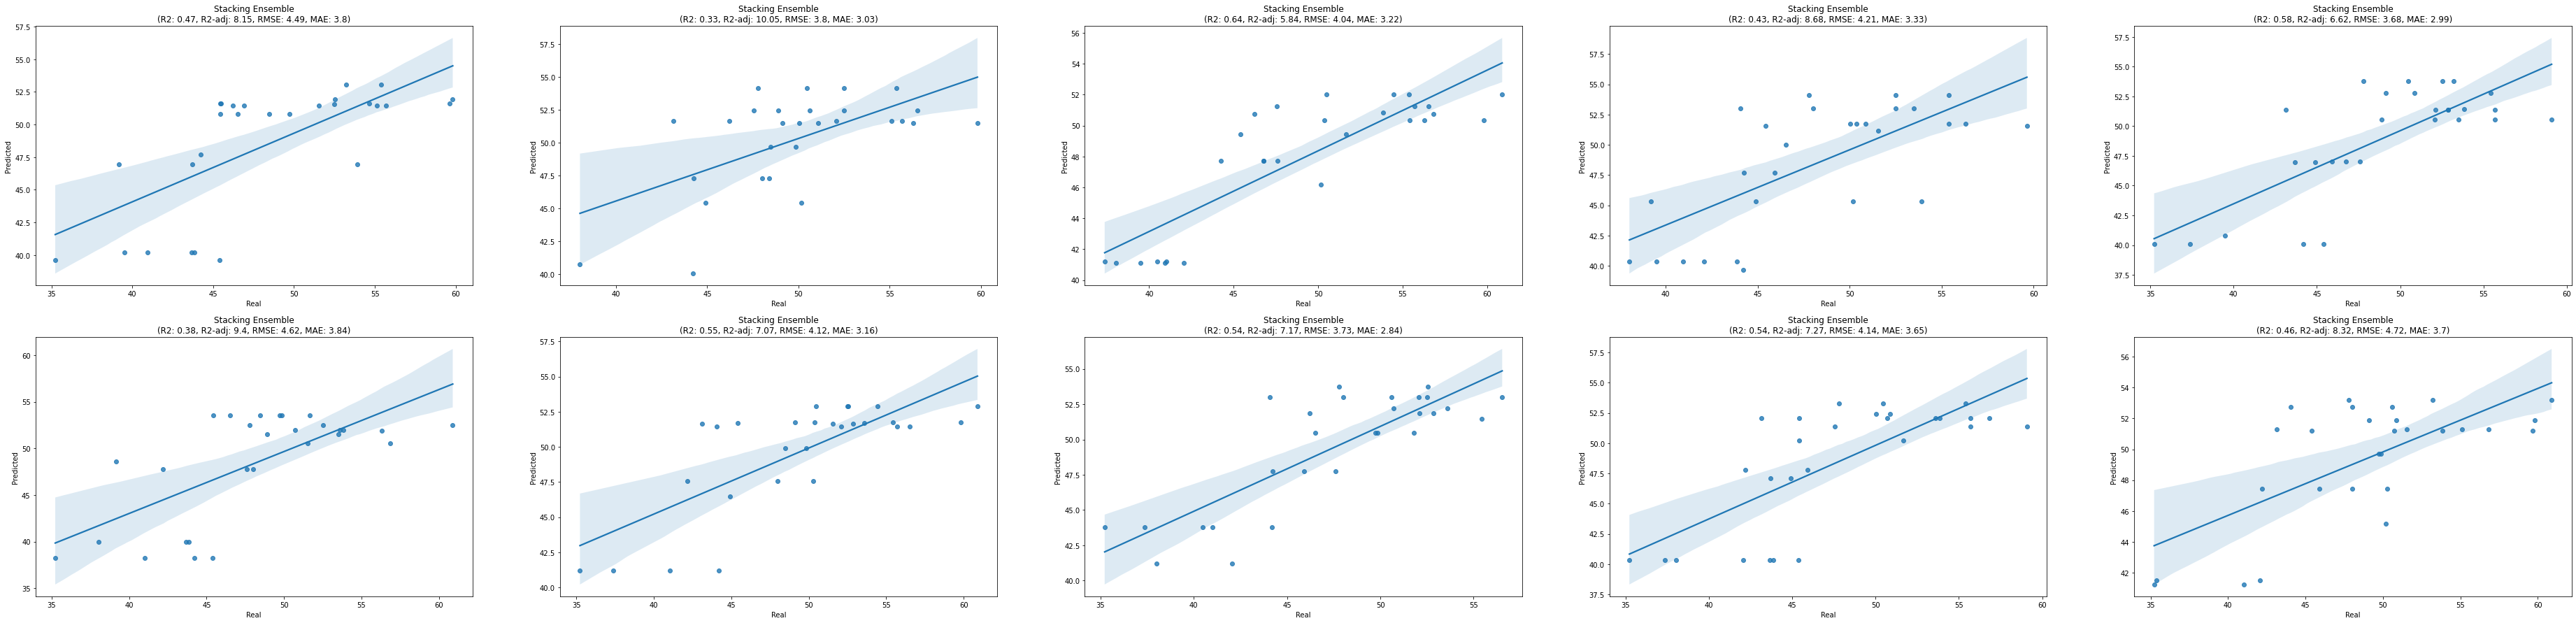

In [33]:
from symbol import eval_input
from sklearn.svm import LinearSVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# evaluate the ensemble across several splits visually
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		mae = mean_absolute_error(y_val, yhat)
		# store the performance
		scores.append(-mae)
		# report model performance
	return scores


X_train, X_valid, y_train, y_valid=train_test_split(dfData, y,train_size=0.666, test_size=0.333,random_state=2)
#holdout for testing the valid

# fit and evaluate each model with 10 shuffle splits (same as when they were optimised)
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=10, test_size=.33, random_state=0)
rs.get_n_splits(X_train)
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(65, 15)
row=0
column=0
mean_errors=[]
r2_scores=[]
for train_index, test_index in rs.split(X_train):
    X_train2=X_train.iloc[train_index,:]
    y_train2=y_train.iloc[train_index]
    X_valid2=X_train.iloc[test_index,:]
    y_valid2=y_train.iloc[test_index]

    # create the ensemble
    ensemble = VotingRegressor(estimators=models, weights=ensemble_weights)

    ensemble.fit(X_train2,y_train2)
    predictions = ensemble.predict(X_valid2)

    
    sns.regplot(ax=axes[column,row],x=y_valid2,y=predictions)
    axes[column,row].set_title("Stacking Ensemble\n(R2: "+str(round(r2_score(y_valid2,predictions),2))+", R2-adj: "+str(round(1-(1-r2_score(y_valid2, predictions))*((len(y_valid2)-1)/(len(y_valid2)-len(X_valid2.columns)-1)),2))+", RMSE: "+str(round(np.sqrt(mean_squared_error(y_valid2,predictions)),2))+", MAE: "+str(round(mean_absolute_error(y_valid2,predictions),2))+")",fontsize=12)
    axes[column,row].set_xlabel('Real')
    axes[column,row].set_ylabel('Predicted')
    row=row+1
    if row==5:
        row=0
        column=1
    mean_errors.append(mean_absolute_error(y_valid2,predictions))
    r2_scores.append(r2_score(y_valid2,predictions))

print(np.mean(mean_errors))
print(np.mean(r2_scores))

n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.
n_quantiles (1860) is greater than the total number of samples (55). n_quantiles i

[3.801226704969366, 3.034072508842147, 3.220193022329688, 3.3264732593989876, 2.985184417008253, 3.8357542836511977, 3.1567032772034125, 2.8444440195431535, 3.649366261362381, 3.7024797073899336, 3.5801446922019866, 3.232962398141281, 3.23845873241329, 3.0326445882965607, 3.008393961724923, 3.5100058379787122, 3.157883084710337, 2.8009722056972377, 2.3118433340025106, 2.4127612182434013, 3.8957403495693943, 3.5453385203301315, 3.030590780738718, 3.302517916794922, 3.329620626791978, 3.228832101394945, 3.372735827824467, 2.750302301359239, 2.7305156445969905, 3.0746938746641126, 2.7364216724125745, 3.3270740531247074, 3.0974596153420535, 3.2065146544075147, 3.6581978738581262, 3.116510543222751, 3.3688443208634262, 3.753853343930352, 3.224532798712007, 2.8546198176494584, 3.4971577131949823, 3.0861919729352145, 3.104498302756578, 2.810415440551636, 3.426045352212795, 3.1355449817226306, 3.882401571301028, 3.127423598287335, 3.3173573878381535, 2.7093347368028, 3.7220456077574013, 2.7982

n_quantiles (1860) is greater than the total number of samples (55). n_quantiles is set to n_samples.


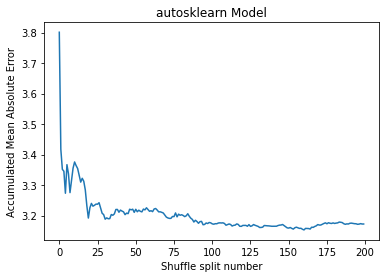

[0.47051112731348854, 0.3294592414395483, 0.6413013555756222, 0.43087825389353085, 0.5835064663169864, 0.37762664484392217, 0.5500971040036559, 0.5431332722583676, 0.5358103594730979, 0.4577558884711823, 0.5053699530974627, 0.5232761480226347, 0.4020479999405254, 0.3909413839794986, 0.553982643739013, 0.5648371531023816, 0.541309503964966, 0.6419340758126693, 0.5612364734851298, 0.6747487781621672, 0.1180239655432842, 0.4324052091678191, 0.38177076639042595, 0.5566503492279384, 0.4540393673677612, 0.4397356584095936, 0.5407102963417263, 0.625287793281082, 0.34367826834422077, 0.44597316860638936, 0.6123873705485232, 0.4182550909377374, 0.4374956755780325, 0.4459855382248922, 0.4666003252958739, 0.2906698494047266, 0.5642650980351045, 0.3853651442817835, 0.4833187777122111, 0.5864133592172985, 0.5439452242373307, 0.647686698273887, 0.4889758752853467, 0.2872239038324115, 0.5579053867487582, 0.6306407687391871, 0.46014016052595463, 0.6233187546019239, 0.5815758836965903, 0.66098119817408

Text(0, 0.5, 'Accumulated R2')

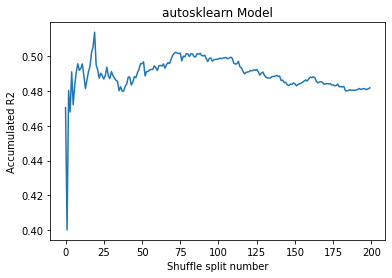

In [34]:
#even more splits to test the stability with accumulated averages
rs = ShuffleSplit(n_splits=200, test_size=.33, random_state=0)
rs.get_n_splits(X_train)
mean_errors=[]
r2_scores=[]
for train_index, test_index in rs.split(X_train):
    X_train2=X_train.iloc[train_index,:]
    y_train2=y_train.iloc[train_index]
    X_valid2=X_train.iloc[test_index,:]
    y_valid2=y_train.iloc[test_index]
    # create the ensemble
    ensemble = VotingRegressor(estimators=models, weights=ensemble_weights)
    ensemble.fit(X_train2,y_train2)
    predictions = ensemble.predict(X_valid2)
    mean_errors.append(mean_absolute_error(y_valid2,predictions))
    r2_scores.append(r2_score(y_valid2,predictions))

accumulated_averages=[]
for i in range(len(mean_errors)):
    level=[mean_errors[z] for z in range(0,i+1)]
    accumulated_averages.append(np.mean(level))
print(mean_errors)
print(accumulated_averages)
plt.plot(accumulated_averages)

plt.title('autosklearn Model')
plt.xlabel('Shuffle split number')
plt.ylabel('Accumulated Mean Absolute Error')
plt.show()

accumulated_r2=[]
for i in range(len(r2_scores)):
    level=[r2_scores[z] for z in range(0,i+1)]
    accumulated_r2.append(np.mean(level))
print(r2_scores)
print(accumulated_r2)
plt.plot(accumulated_r2)

plt.title('autosklearn Model')
plt.xlabel('Shuffle split number')
plt.ylabel('Accumulated R2')

n_quantiles (1860) is greater than the total number of samples (83). n_quantiles is set to n_samples.
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names


  0%|          | 0/42 [00:00<?, ?it/s]

X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature nam

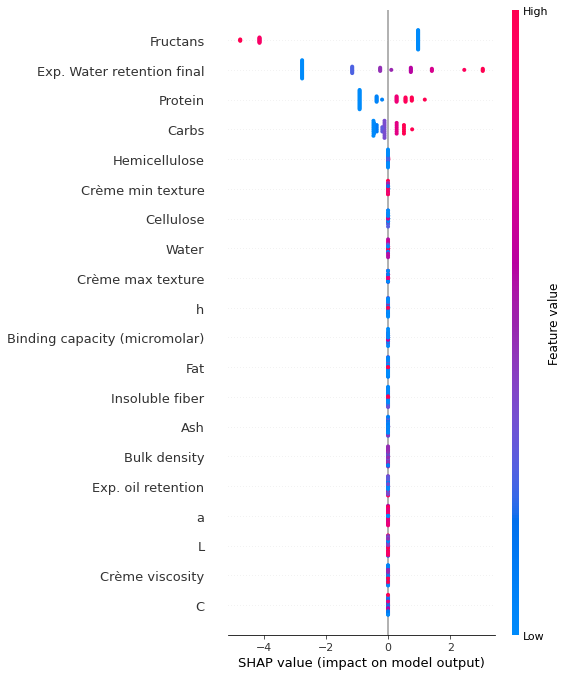

In [35]:
import shap
#Lovely shap summary plots

# Create object that can calculate shap values
# calculate shap values. This is what we will plot.Calculate shap_values for all of val_X rather than a single row, to have more data for plot.

ensemble.fit(X_train,y_train)
explainer = shap.KernelExplainer(ensemble.predict, X_train)
shap_values = explainer.shap_values(X_valid)

# Make plot
shap.summary_plot(shap_values, X_valid)

In [36]:
# Permutation importance
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(ensemble, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.3404 ± 0.1977,Fructans
0.1774 ± 0.0749,Exp. Water retention final
0.0245 ± 0.0481,Protein
0.0161 ± 0.0343,Carbs
0.0001 ± 0.0001,Cellulose
0.0000 ± 0.0000,Binding capacity (micromolar)
0.0000 ± 0.0001,Hemicellulose
0.0000 ± 0.0000,Insoluble fiber
0.0000 ± 0.0000,C
0.0000 ± 0.0000,Pectin
